In [1]:
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python import debug as tf_debug
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'   #指定第一块GPU可用
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.75  # 程序最多只能占用指定gpu50%的显存
config.gpu_options.allow_growth = True      #程序按需申请内存
# sess = tf.Session(config = config)
# hello = tf.constant('Hello, TensorFlow!')

# print(sess.run(hello))
# sess.close()

F:\Users\lizeda\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
LOG_DIR = 'logs'

mnist = input_data.read_data_sets('MNIST_data')
images = tf.Variable(mnist.test.images, name='images')

with tf.Session(config = config) as sess:
    saver = tf.train.Saver([images])

    sess.run(images.initializer)
    saver.save(sess, os.path.join(LOG_DIR, 'images.ckpt'))

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.tensorboard.plugins import projector

In [ ]:
daytime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())[5:16].replace(" ","-").replace(":","-" )
daytime
with open(metadata, 'w') as metadata_file:
    for row in mnist.test.labels[:200]:
        metadata_file.write('%d\n' % row)
daytime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())[5:16].replace(" ","|").replace(":","|" )

In [6]:
LOG_DIR = 'logs'
ospath = os.getcwd()

metadata = os.path.join(ospath, LOG_DIR, 'metadata.tsv')#.replace("\\", '/')

mnist = input_data.read_data_sets('MNIST_data')
images = tf.Variable(mnist.test.images[:200], name='images')

with open(metadata, 'w') as metadata_file:
    for row in mnist.test.labels[:200]:
        metadata_file.write('%d\n' % row)
daytime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())[5:16].replace(" ","-").replace(":","-" )

with tf.Session(config = config) as sess:
    saver = tf.train.Saver([images])

    sess.run(images.initializer)
    saver.save(sess, os.path.join(LOG_DIR, daytime+'.ckpt'))
    
    Config = projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = Config.embeddings.add()
    embedding.tensor_name = images.name
    # Link this tensor to its metadata file (e.g. labels).
    embedding.metadata_path = metadata
    # Saves a config file that TensorBoard will read during startup.
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), Config)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [3]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy.io as scio
from scipy import stats
from initializations import random_mini_batches
from dnn_app_utils_v2 import load_data, predict, print_mislabeled_images
from autoencoder_tensorflow import autoencoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# from __future__ import division, print_function, absolute_import

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
#%reload_ext autoreload
%autoreload 2

np.random.seed(1)

ok


In [8]:
import sys
import urllib

if sys.version_info[0] >= 3:
    from urllib.request import urlretrieve
else:
    from urllib import urlretrieve


In [10]:
LOGDIR = '/tmp/mnist_tutorial/'
GITHUB_URL ='https://raw.githubusercontent.com/mamcgrath/TensorBoard-TF-Dev-Summit-Tutorial/master/'

### MNIST EMBEDDINGS ###
mnist = tf.contrib.learn.datasets.mnist.read_data_sets(train_dir=LOGDIR + 'data', one_hot=True)
### Get a sprite and labels file for the embedding projector ###
urlretrieve(GITHUB_URL + 'labels_1024.tsv', LOGDIR + 'labels_1024.tsv')
urlretrieve(GITHUB_URL + 'sprite_1024.png', LOGDIR + 'sprite_1024.png')

Extracting /tmp/mnist_tutorial/data\train-images-idx3-ubyte.gz
Extracting /tmp/mnist_tutorial/data\train-labels-idx1-ubyte.gz
Extracting /tmp/mnist_tutorial/data\t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist_tutorial/data\t10k-labels-idx1-ubyte.gz


('/tmp/mnist_tutorial/sprite_1024.png',
 <http.client.HTTPMessage at 0xa783723080>)

In [11]:
# Add convolution layer
def conv_layer(input, size_in, size_out, name="conv"):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([5, 5, size_in, size_out], stddev=0.1), name="W")
        b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="B")
        conv = tf.nn.conv2d(input, w, strides=[1, 1, 1, 1], padding="SAME")
        act = tf.nn.relu(conv + b)
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
        return tf.nn.max_pool(act, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")


# Add fully connected layer
def fc_layer(input, size_in, size_out, name="fc"):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([size_in, size_out], stddev=0.1), name="W")
        b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="B")
        act = tf.nn.relu(tf.matmul(input, w) + b)
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
        return act


def mnist_model(learning_rate, use_two_conv, use_two_fc, hparam):
    tf.reset_default_graph()
    sess = tf.Session()

    # Setup placeholders, and reshape the data
    x = tf.placeholder(tf.float32, shape=[None, 784], name="x")
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    tf.summary.image('input', x_image, 3)
    y = tf.placeholder(tf.float32, shape=[None, 10], name="labels")

    if use_two_conv:
        conv1 = conv_layer(x_image, 1, 32, "conv1")
        conv_out = conv_layer(conv1, 32, 64, "conv2")
    else:
        conv1 = conv_layer(x_image, 1, 64, "conv")
        conv_out = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

    flattened = tf.reshape(conv_out, [-1, 7 * 7 * 64])


    if use_two_fc:
        fc1 = fc_layer(flattened, 7 * 7 * 64, 1024, "fc1")
        embedding_input = fc1
        embedding_size = 1024
        logits = fc_layer(fc1, 1024, 10, "fc2")
    else:
        embedding_input = flattened
        embedding_size = 7*7*64
        logits = fc_layer(flattened, 7*7*64, 10, "fc")

    with tf.name_scope("xent"):
        xent = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits=logits, labels=y), name="xent")
        tf.summary.scalar("xent", xent)

    with tf.name_scope("train"):
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(xent)

    with tf.name_scope("accuracy"):
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar("accuracy", accuracy)

    summ = tf.summary.merge_all()


    embedding = tf.Variable(tf.zeros([1024, embedding_size]), name="test_embedding")
    assignment = embedding.assign(embedding_input)
    saver = tf.train.Saver()

    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(LOGDIR + hparam)
    writer.add_graph(sess.graph)

    config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
    embedding_config = config.embeddings.add()
    embedding_config.tensor_name = embedding.name
    embedding_config.sprite.image_path = LOGDIR + 'sprite_1024.png'
    embedding_config.metadata_path = LOGDIR + 'labels_1024.tsv'
    # Specify the width and height of a single thumbnail.
    embedding_config.sprite.single_image_dim.extend([28, 28])
    tf.contrib.tensorboard.plugins.projector.visualize_embeddings(writer, config)

    for i in range(2001):
        batch = mnist.train.next_batch(100)
        if i % 5 == 0:
          [train_accuracy, s] = sess.run([accuracy, summ], feed_dict={x: batch[0], y: batch[1]})
          writer.add_summary(s, i)
        if i % 500 == 0:
          sess.run(assignment, feed_dict={x: mnist.test.images[:1024], y: mnist.test.labels[:1024]})
          saver.save(sess, os.path.join(LOGDIR, "model.ckpt"), i)
        sess.run(train_step, feed_dict={x: batch[0], y: batch[1]})

def make_hparam_string(learning_rate, use_two_fc, use_two_conv):
    conv_param = "conv=2" if use_two_conv else "conv=1"
    fc_param = "fc=2" if use_two_fc else "fc=1"
    return "lr_%.0E,%s,%s" % (learning_rate, conv_param, fc_param)

def main():
  # You can try adding some more learning rates
    for learning_rate in [1E-4]:
    # Include "False" as a value to try different model architectures
        for use_two_fc in [True]:
            for use_two_conv in [True]:
                # Construct a hyperparameter string for each one (example: "lr_1E-3,fc=2,conv=2)
                hparam = make_hparam_string(learning_rate, use_two_fc, use_two_conv)
                print('Starting run for %s' % hparam)

                # Actually run with the new settings
                mnist_model(learning_rate, use_two_fc, use_two_conv, hparam)

In [12]:
main()

Starting run for lr_1E-04,conv=2,fc=2
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [40]:
# GRADED FUNCTION: one_hot_matrix

def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """

    # Create a tf.constant equal to C (depth), name it 'C'. (approx. 1 line)
    C = tf.constant(C,name='C')
    # Use tf.one_hot, be careful with the axis (approx. 1 line)
    one_hot_matrix = tf.one_hot(labels,C,axis=0)
    # Create the session (approx. 1 line)
    sess = tf.Session()
    # Run the session (approx. 1 line)
    one_hot = sess.run(one_hot_matrix)
    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
    
    return one_hot

In [41]:
# calculate the features in time scale
def features_time(De_A):
    '''
    Calculate the features in time scaleC
    
    Returns:
    xba -- The mean value of each column(sample)
    xr --  
    '''
    xba = np.mean(De_A)
    De_A = De_A - xba # sets zero mean
    xr = np.mean(np.sqrt(np.abs(De_A)))**2
    xrms = np.sqrt(np.mean(De_A**2))
    xmax = np.max(np.abs(De_A))
    xpp = np.ptp(De_A)
    xstd = np.std(De_A)
    xvar = np.var(De_A)
    #xskew = (np.mean(De_A**3)-3*xba*(xstd**2)-xba**3)/xstd**3
    #xalpha = np.sum((De_A-p1)**3)/((ln-1)*p5**3)
    #xkurt = np.mean(De_A**4)/xstd**4
    xskew = stats.skew(De_A)[0]
    xkurt = stats.kurtosis(De_A)[0]
    xmean = np.mean(np.abs(De_A))
    xk = xrms/xmean
    xc = xmax/xrms
    xi = xmax/xmean
    xl = xmax/xr
    ff = np.fft.fft(De_A)
    ff = np.abs(ff)
    assert(ff.shape == De_A.shape)
    ff = ff[:int(ff.shape[0]/2)]
    features = [xba,xr,xrms,xmax,xpp,xstd,xvar,xskew,xkurt,xmean,xk,xc,xi,xl]
    features.extend(ff)
    features = np.array(features)
    return features

def features_freq(De_A):
    ff = np.fft.fft(De_A)
    ff = np.abs(ff)
    assert(ff.shape == De_A.shape)
    ff = ff[:int(ff.shape[0]/2)]
    return ff

## CWUR BEARING DATA

In [29]:
filepath = r"F:\work files\The way to data science\Python for Data Science\De.npy"
filepath2 = r"F:\work files\The way to data science\Python for Data Science\data_ft.npy"
filepath3 = r"F:\work files\The way to data science\Python for Data Science\De_no28.npy"

In [30]:
De_orig = np.load(filepath3)
De_orig.shape

(154,)

In [31]:
De_orig_12K = De_orig[:97]
De_orig_48K = De_orig[97:-5]
De_orig_Normal = De_orig[-5:-1]

In [32]:
De_orig_12K.shape, De_orig_48K.shape, De_orig_Normal.shape

((97,), (52,), (4,))

Input data was raw data points in time domain

In [33]:
# The number of samples
signals_num = []              #The number of splited signals of each examples
new_signals = []
#labels_num = [40,40,77,4]
labels = []                   #Contain labels corresponding to the splited signals 

for i in range(De_orig_12K.shape[0]):        #De_orig[-1] contains the labels of the raw data
    signal_length = De_orig_12K[i].shape[0]
    signals_num.append(signal_length//2048)
    choice_j = []
    for n in range(signals_num[-1]*3):
        j = n * 2048 if n < signals_num[-1] else np.random.choice(signal_length-2048) 
        while j in choice_j :
            j = np.random.choice(signal_length-2048)
        choice_j.append(j)
        new_signals.append(De_orig_12K[i][j:j+2048])
        labels.append(De_orig[-1][i])
    #print(len(choice_j), len(set(choice_j)))

In [34]:
len(choice_j), len(set(choice_j))

(174, 174)

Extract features from the data

In [12]:
from multiprocessing.dummy import Pool as ThreadPool 

In [13]:
%%time
pool = ThreadPool()
data_X_feat = pool.map(features_time, new_signals)
pool.close()
pool.join()

Wall time: 16.7 s


In [14]:
%%time
pool = ThreadPool()
data_X_feaf = pool.map(features_freq, new_signals)
pool.close()
pool.join()

Wall time: 656 ms


In [15]:
data_X_feat = np.array(data_X_feat)
data_X_feaf = np.squeeze(data_X_feaf)
data_X_feat.shape, data_X_feaf.shape

((17157, 1038), (17157, 1024))

In [16]:
type(data_X_feaf)

numpy.ndarray

Take raw data points

In [35]:
new_signals = np.squeeze(new_signals)
labels = np.array(labels)
new_signals.shape, len(labels)

((17157, 2048), 17157)

In [36]:
data_X = preprocessing.minmax_scale(new_signals)
data_Y = labels

In [37]:
data_Xs = preprocessing.scale(new_signals)

Divide the data into train set and validation set

In [38]:
train_x, test_x, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.33, random_state=244)
train_xs, test_xs, train_ys, test_ys = train_test_split(data_Xs, data_Y, test_size=0.33, random_state=244)
# train_xft, test_xt, train_y, test_y = train_test_split(data_X_feat, data_Y, test_size=0.33, random_state=244)
# train_xf, test_xf, train_y, test_y = train_test_split(data_X_feaf, data_Y, test_size=0.33, random_state=244)

In [42]:
#labels = np.array([1,2,3,0,2,1])
train_labels, test_labels = train_y.astype("str") , test_y.astype("str") 
print(test_labels[:3])
train_y = one_hot_matrix(train_y, C = 10)
test_y = one_hot_matrix(test_y, C = 10)

['7' '6' '4']


In [43]:
EBlabelstr = np.vstack((train_labels, train_labels)).T#np.ones([train_labels.shape[0], 2], dtype=str)
EBlabelste = np.vstack((test_labels, test_labels)).T

In [44]:
text_labels = ['RF_007', 'RF_014', 'RF_021', 'IF_007', 'IF_014', 'IF_021',  'OF_007', 'OF_014', 'OF_021', 'Normal']
train_labels, test_labels

for i in range(10):
    EBlabelste[EBlabelste[:, 0]==str(i), 0] = text_labels[i]
    EBlabelstr[EBlabelstr[:, 0]==str(i), 0] = text_labels[i]

In [45]:
EBlabelste,EBlabelstr

(array([['OF_014', '7'],
        ['OF_007', '6'],
        ['IF_014', '4'],
        ...,
        ['IF_021', '5'],
        ['IF_021', '5'],
        ['OF_021', '8']], dtype='<U11'), array([['IF_021', '5'],
        ['IF_007', '3'],
        ['IF_014', '4'],
        ...,
        ['IF_021', '5'],
        ['IF_007', '3'],
        ['OF_007', '6']], dtype='<U11'))

In [46]:
print ("one_hot = " + str(test_y[:,:3]))

one_hot = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [47]:
train_x = train_x.T
test_x = test_x.T
train_xs = train_xs.T
test_xs = test_xs.T
# train_xf = train_xf.T
# test_xf = test_xf.T

In [49]:
print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))
# print ("train_xf's shape: " + str(train_xf.shape))
# print ("test_xf's shape: " + str(test_xf.shape))
print ("train_y's shape: " + str(train_y.shape))
print ("test_y's shape: " + str(test_y.shape))

train_x's shape: (2048, 11495)
test_x's shape: (2048, 5662)
train_y's shape: (10, 11495)
test_y's shape: (10, 5662)


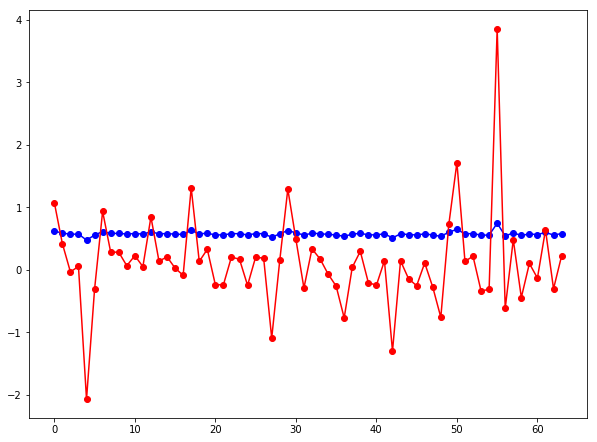

In [50]:
plt.figure(figsize=(10,7.5))
plt.plot(list(range(64)), train_x[1][:64], "bo-")
plt.plot(list(range(64)), train_xs[1][:64], "ro-")
plt.show()

### MNIST　DATA

In [13]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True) 

ok
Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


(784, 1024) (10, 1024) (784, 1024) (10, 1024)
(55000, 784)
(55000, 10)


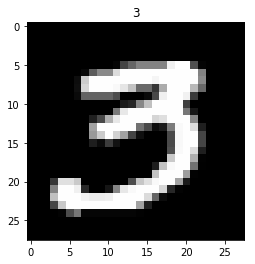

train_x's shape: (784, 1024)
test_x's shape: (784, 1024)
train_y's shape: (10, 1024)
test_y's shape: (10, 1024)


In [14]:
test_x = mnist.test.images.T[:, :1024]
test_y = mnist.test.labels.T[:, :1024]

train_x = mnist.train.images.T[:, :1024]
train_y = mnist.train.labels.T[:, :1024]
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
# plot one example
print(mnist.train.images.shape)     # (55000, 28 * 28)
print(mnist.train.labels.shape)     # (55000, 10)
plt.imshow(train_x[:,511].reshape((28, 28)), cmap='gray')
plt.title('%i' % np.argmax(train_y[:,511]))
plt.show()
print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))
print ("train_y's shape: " + str(train_y.shape))
print ("test_y's shape: " + str(test_y.shape))

## Model

In [15]:
ae = autoencoder()

In [51]:
LOG_DIR = "logs\\aetrain"
ospath = os.getcwd()

metadata = os.path.join(ospath, LOG_DIR, 'aelabels.tsv')#.replace("\\", '/')
print("labels' path:", metadata)
with open(metadata, 'w') as metadata_file:
    metadata_file.write("Index\tLabel\n")
    for row in EBlabelste:
        index = row[0]
        label = int(row[1])
        metadata_file.write("%s\t%d\n" % (index,label))

labels' path: F:\work files\The way to data science\Auto encoder\logs\aetrain\aelabels.tsv


In [17]:
LOG_DIR = "logs\\aetrain"
ospath = os.getcwd()

metadata = os.path.join(ospath, LOG_DIR, 'minstlabels.tsv')#.replace("\\", '/')
print("labels' path:", metadata)
with open(metadata, 'w') as metadata_file:
    metadata_file.write("Index\tLabel\n")
    for row in range(1024):
        index = np.argmax(test_y[:, row])
        label = np.argmax(test_y[:, row])
        metadata_file.write("%s\t%s\n" % (index,label))

labels' path: F:\work files\The way to data science\Auto encoder\logs\aetrain\minstlabels.tsv


labels' path: F:\work files\The way to data science\Auto encoder\logs\aetrain
This is the 1th training...
single_aemodel0——tf.get_collection('ae_losses')————> []
(2048, 11495)
pool_ed size: 512
(512, 11495)
(2048, 5662)
pool_ed size: 512
(512, 5662)
n_x————> 512
single_aemodel0——X————> Tensor("Placeholder:0", shape=(512, ?), dtype=float32)
layers' dimensions: [512, 256, 512]
initialize_parameters——parameters.keys()————> dict_keys(['W1', 'b2', 'W2', 'b1'])
single_aemodel0——parameters————> {'W1': <tf.Variable 'W1:0' shape=(256, 512) dtype=float32_ref>, 'b2': <tf.Variable 'Variable_1:0' shape=(512, 1) dtype=float32_ref>, 'W2': <tf.Variable 'W2:0' shape=(512, 256) dtype=float32_ref>, 'b1': <tf.Variable 'Variable:0' shape=(256, 1) dtype=float32_ref>}
the shape of encodered data—A————> (256, ?)
the shape of encodered data—A————> (256, ?)
the shape of decodered data—A————> (512, ?)
single_aemodel0——AL————> Tensor("Relu_2:0", shape=(512, ?), dtype=float32)
compute_cost——tf.get_collection('ae_l

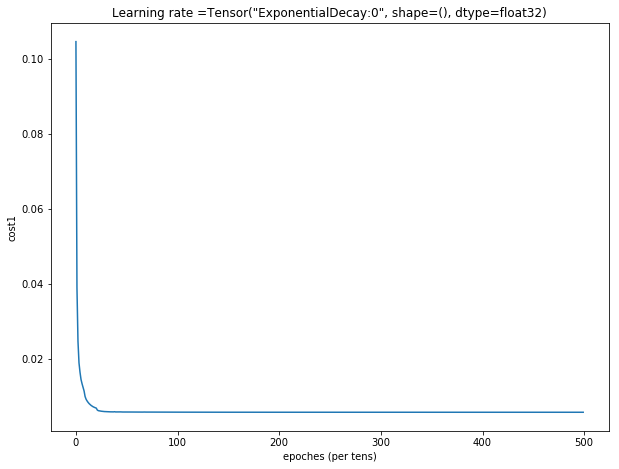

Parameters have been trained! {'W1': <tf.Variable 'W1:0' shape=(256, 512) dtype=float32_ref>, 'b2': <tf.Variable 'Variable_1:0' shape=(512, 1) dtype=float32_ref>, 'W2': <tf.Variable 'W2:0' shape=(512, 256) dtype=float32_ref>, 'b1': <tf.Variable 'Variable:0' shape=(256, 1) dtype=float32_ref>}
[[-0.01358089]
 [-0.01801005]
 [-0.00232825]
 [-0.0176615 ]
 [-0.00020439]]
***************************************************************************************************
All autoencoder parameters dict_keys(['W1', 'b2', 'b1', 'W2'])


In [54]:
layers = [2048, 256]
#layers = [784, 256]
features_ae, aeparams = ae.stackedAE(train_x, test_x, layers, learning_rate=[0.003, 3e-05], pool_f = 4,stride=4,training_epochs=[500, 100], 
                  display_step=[10, 1], batch_size=256, keep_prob = 1, fine_tune = False, decay_rate = 0.9, decay_steps = 2000, rho = 0,
                                    sparse_beta = 0.1, lambd=0.0001)

In [56]:
Ffeatures_ae, Aaeparams = features_ae, aeparams
Ffeatures_ae[1].shape, Aaeparams.keys()

((256, 5662), dict_keys(['W1', 'b1']))

In [55]:
w1 = Aaeparams["W1"]

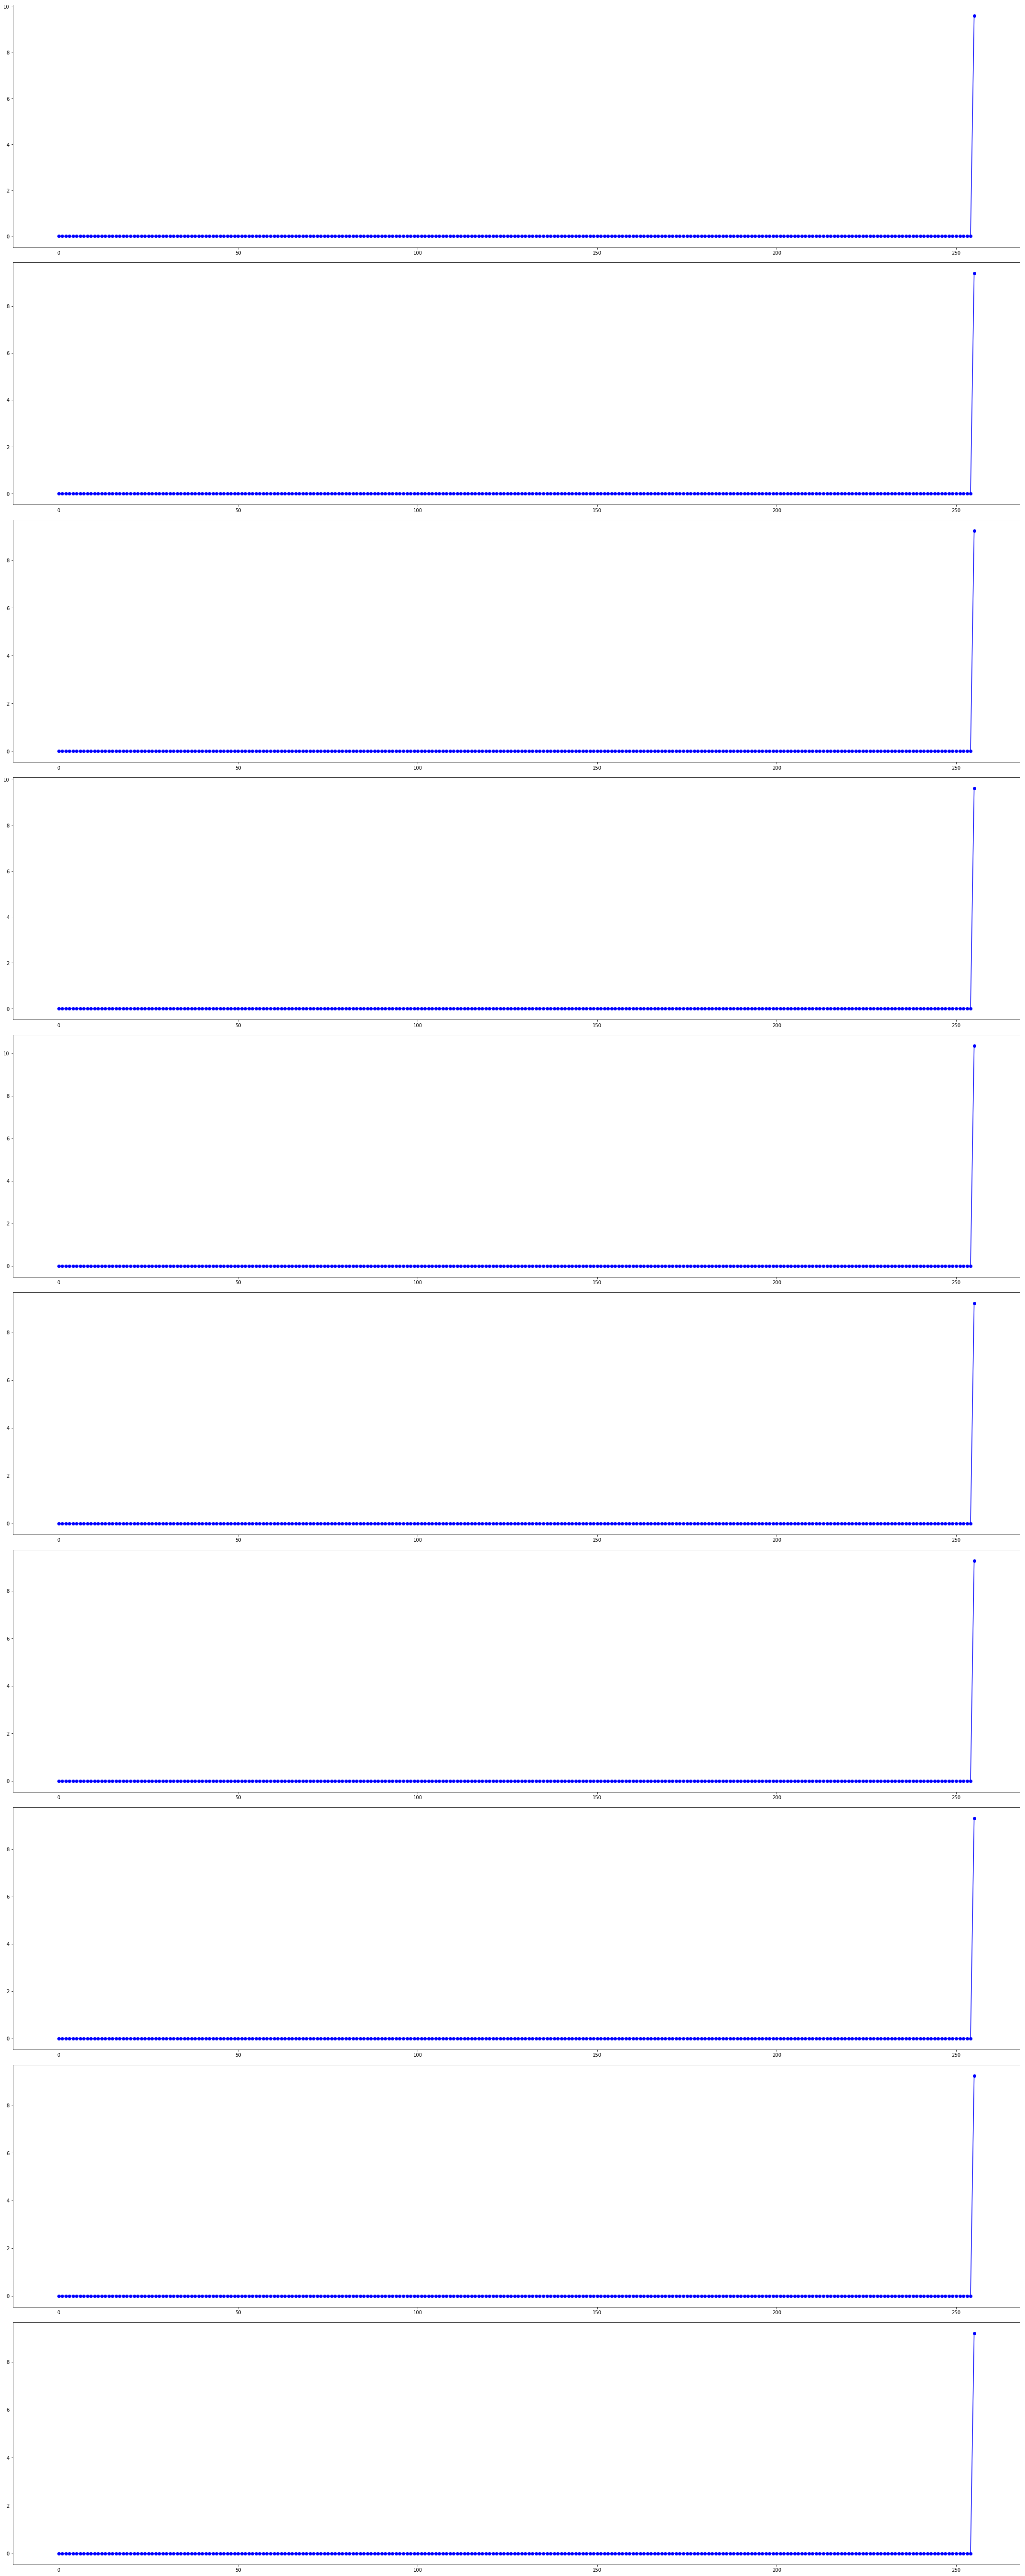

In [57]:
f, a = plt.subplots(10,1, figsize=(15*2, 7.5*10))
f.tight_layout()
for i in range(10):
    w1 = np.sort(np.abs(Ffeatures_ae[0])[:, i])
    #w11 = np.sort(np.abs(aeparams["W1"][i]))
    a[i].plot(w1, "bo-")
    #a[i].plot(w11, "ro-")
plt.show()

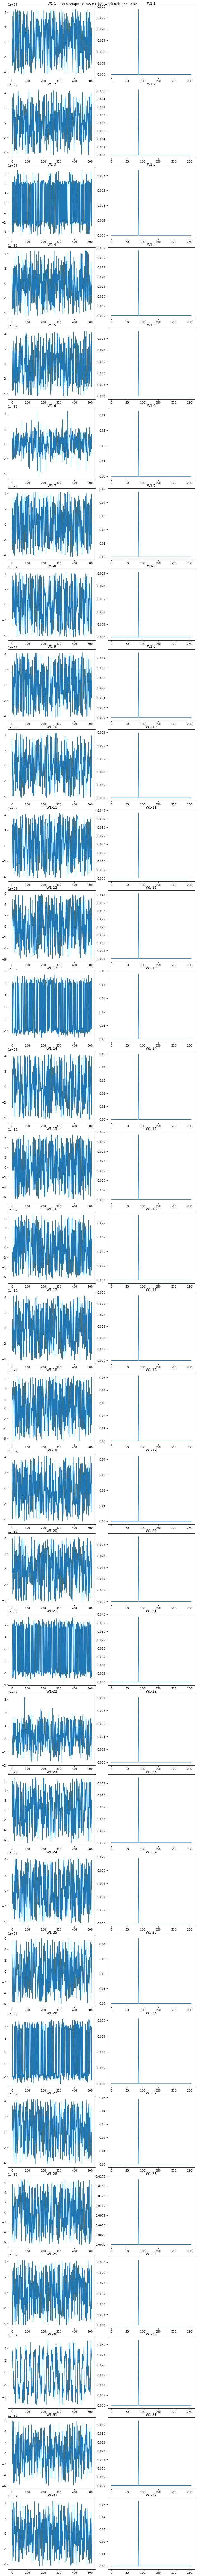

In [58]:
L = len(Aaeparams)
f, a = plt.subplots(32,2, figsize=(5*2, 4*32))
f.tight_layout()
f.suptitle("W's shape-->(32, 64)|Network units:64-->32", y =1, verticalalignment='top')
#Aaeparams["W2"].shape
n, m = 0, 0
for name, value in Aaeparams.items():
    if "W1" in name:
        value = Aaeparams["W1"]
        #a[0][n].set_title(name)
        for i in range(32):
            a[i][0].set_title(name+"-"+str(i+1))
            a[i][0].plot(value[i])
            
        for i in range(32):#value.shape[1]
            a[i][1].set_title(name+"-"+str(i+1))
            a[i][1].plot(value[:, i])
        plt.show()

In [88]:
features_ae[0].shape,features_ae[1].shape

((32, 13701), (2048, 3426))

Start to train softmax layer...
[]
(2048, 11495)
pool_ed size: 512
(512, 11495)
(2048, 5662)
pool_ed size: 512
(512, 5662)
[512, 256, 10]
X,Y———> Tensor("Placeholder:0", shape=(512, ?), dtype=float32) Tensor("Placeholder_1:0", shape=(10, ?), dtype=float32)
initialize_parameters_softmax——parameters.keys()————> dict_keys(['softmaxb', 'W1', 'softmaxW', 'b1'])
parameters———> {'softmaxb': <tf.Variable 'Variable:0' shape=(10, 1) dtype=float32_ref>, 'W1': <tf.Variable 'W1:0' shape=(256, 512) dtype=float32_ref>, 'softmaxW': <tf.Variable 'softmaxW:0' shape=(10, 256) dtype=float32_ref>, 'b1': <tf.Variable 'b1:0' shape=(256, 1) dtype=float32_ref>}
the shape of encodered data—A————> (256, ?)
AL———> Tensor("Add_1:0", shape=(10, ?), dtype=float32)
compute_softmax_loss——tf.get_collection('losses')————> [<tf.Tensor 'l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'l2_regularizer_1:0' shape=() dtype=float32>, <tf.Tensor 'Mean:0' shape=() dtype=float32>]
After global init——sess.run(parameters['b1'

Epoch: 0063 loss= 0.959239786 learning rate tensor= 0.008000000 Train Accuracy: 0.79947805 Test Accuracy: 0.6657
Epoch: 0064 loss= 0.962375795 learning rate tensor= 0.008000000 Train Accuracy: 0.77390170 Test Accuracy: 0.6602
Epoch: 0065 loss= 0.960683945 learning rate tensor= 0.008000000 Train Accuracy: 0.79878205 Test Accuracy: 0.6759
Epoch: 0066 loss= 0.967327874 learning rate tensor= 0.007200000 Train Accuracy: 0.80304480 Test Accuracy: 0.6710
Epoch: 0067 loss= 0.954826148 learning rate tensor= 0.007200000 Train Accuracy: 0.80017400 Test Accuracy: 0.6690
Epoch: 0068 loss= 0.940054604 learning rate tensor= 0.007200000 Train Accuracy: 0.82331449 Test Accuracy: 0.6869
Epoch: 0069 loss= 0.950361614 learning rate tensor= 0.007200000 Train Accuracy: 0.77816445 Test Accuracy: 0.6577
Epoch: 0070 loss= 0.921042437 learning rate tensor= 0.007200000 Train Accuracy: 0.80478472 Test Accuracy: 0.6764
Epoch: 0071 loss= 0.907829300 learning rate tensor= 0.007200000 Train Accuracy: 0.83531970 Test 

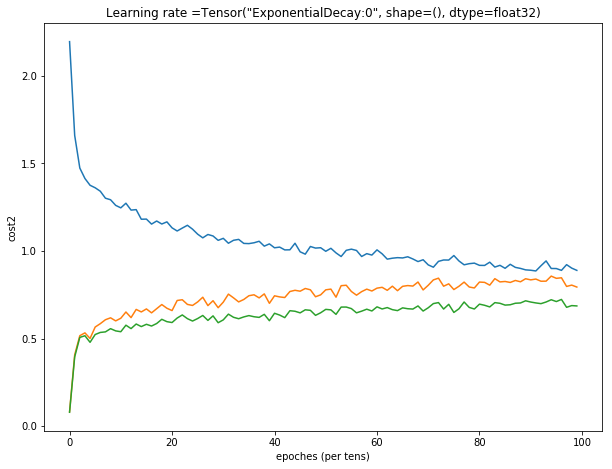

Train Accuracy: 0.84254026
Test Accuracy: 0.7036383


In [63]:
layers = [2048, 256, 10]
parameters = ae.fineTune(train_xs, train_y, test_xs, test_y, layers, learning_rate=0.008, training_epochs=100, display_step=1,
                        batch_size=256, pool_f =4, stride=4, pythondict=aeparams, keep_prob = 1,  decay_rate = 0.9,
                         decay_steps = 3000, lambd=0.001)

In [64]:
layers = [256, 10]
parameters = ae.fineTune(Ffeatures_ae[0], train_y, Ffeatures_ae[1], test_y, layers, learning_rate=0.01, training_epochs=200, display_step=1,
                        batch_size=256, keep_prob=1, lambd = 0.001, decay_rate = 0.9, decay_steps = 1000)

Start to train softmax layer...
[]
X,Y———> Tensor("Placeholder:0", shape=(256, ?), dtype=float32) Tensor("Placeholder_1:0", shape=(10, ?), dtype=float32)
initialize_parameters_softmax——parameters.keys()————> dict_keys(['softmaxb', 'softmaxW'])
parameters———> {'softmaxb': <tf.Variable 'Variable:0' shape=(10, 1) dtype=float32_ref>, 'softmaxW': <tf.Variable 'softmaxW:0' shape=(10, 256) dtype=float32_ref>}
AL———> Tensor("Add:0", shape=(10, ?), dtype=float32)
compute_softmax_loss——tf.get_collection('losses')————> [<tf.Tensor 'l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'Mean:0' shape=() dtype=float32>]
Epoch: 0000 loss= 2.193394401 learning rate tensor= 0.010000000 Train Accuracy: 0.08342758 Test Accuracy: 0.0802
Epoch: 0001 loss= 2.148259721 learning rate tensor= 0.010000000 Train Accuracy: 0.25036973 Test Accuracy: 0.2420
Epoch: 0002 loss= 2.145553719 learning rate tensor= 0.010000000 Train Accuracy: 0.25036973 Test Accuracy: 0.2420
Epoch: 0003 loss= 2.143920216 learning rate te

Epoch: 0068 loss= 2.124673887 learning rate tensor= 0.007290000 Train Accuracy: 0.25036973 Test Accuracy: 0.2420
Epoch: 0069 loss= 2.125956124 learning rate tensor= 0.007290000 Train Accuracy: 0.25036973 Test Accuracy: 0.2420
Epoch: 0070 loss= 2.124287811 learning rate tensor= 0.007290000 Train Accuracy: 0.25036973 Test Accuracy: 0.2420
Epoch: 0071 loss= 2.124285037 learning rate tensor= 0.007290000 Train Accuracy: 0.25036973 Test Accuracy: 0.2420
Epoch: 0072 loss= 2.123704249 learning rate tensor= 0.007290000 Train Accuracy: 0.25036973 Test Accuracy: 0.2420
Epoch: 0073 loss= 2.123223505 learning rate tensor= 0.007290000 Train Accuracy: 0.25036973 Test Accuracy: 0.2420
Epoch: 0074 loss= 2.124386934 learning rate tensor= 0.007290000 Train Accuracy: 0.25036973 Test Accuracy: 0.2420
Epoch: 0075 loss= 2.123147439 learning rate tensor= 0.007290000 Train Accuracy: 0.25036973 Test Accuracy: 0.2420
Epoch: 0076 loss= 2.123566538 learning rate tensor= 0.007290000 Train Accuracy: 0.25036973 Test 

KeyboardInterrupt: 

### Feed data features extracted manually

In [46]:
layers = [1024, 10]
parameters = ae.fineTune(train_xf, train_y, test_xf, test_y, layers, learning_rate=0.0005, training_epochs=100, display_step=1,
                        batch_size=256, keep_prob=0.95, lambd = 0.0001, decay_rate = 0.95, decay_steps = 3000)

Start to train softmax layer...
[]
X,Y———> Tensor("Placeholder:0", shape=(1024, ?), dtype=float32) Tensor("Placeholder_1:0", shape=(10, ?), dtype=float32)
initialize_parameters_softmax——parameters.keys()————> dict_keys(['softmaxW', 'softmaxb'])
parameters———> {'softmaxW': <tf.Variable 'softmaxW:0' shape=(10, 1024) dtype=float32_ref>, 'softmaxb': <tf.Variable 'Variable:0' shape=(10, 1) dtype=float32_ref>}
AL———> Tensor("Add:0", shape=(10, ?), dtype=float32)
compute_softmax_loss——tf.get_collection('losses')————> [<tf.Tensor 'l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'Mean:0' shape=() dtype=float32>]
Epoch: 0000 loss= 2.141672397 learning rate tensor= 0.000500000 Train Accuracy: 0.06959548 Test Accuracy: 0.0625
Epoch: 0001 loss= 2.078911456 learning rate tensor= 0.000500000 Train Accuracy: 0.25376251 Test Accuracy: 0.2471
Epoch: 0002 loss= 2.063845851 learning rate tensor= 0.000500000 Train Accuracy: 0.25906917 Test Accuracy: 0.2439
Epoch: 0003 loss= 2.050738944 learning rate 

KeyboardInterrupt: 

In [220]:
layers = [1024, 10]
parameters = ae.fineTune(train_xf, train_y, test_xf, test_y, layers, learning_rate=0.005, training_epochs=100, display_step=1,
                        batch_size=256, keep_prob=0.95, lambd = 0.0001, decay_rate = 0.95, decay_steps = 3000)

Start to train softmax layer...
[]
X,Y———> Tensor("Placeholder:0", shape=(1024, ?), dtype=float32) Tensor("Placeholder_1:0", shape=(10, ?), dtype=float32)
initialize_parameters_softmax——parameters.keys()————> dict_keys(['softmaxb', 'softmaxW'])
parameters———> {'softmaxb': <tf.Variable 'Variable:0' shape=(10, 1) dtype=float32_ref>, 'softmaxW': <tf.Variable 'softmaxW:0' shape=(10, 1024) dtype=float32_ref>}
AL———> Tensor("Add:0", shape=(10, ?), dtype=float32)
compute_softmax_loss——tf.get_collection('losses')————> [<tf.Tensor 'l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'Mean:0' shape=() dtype=float32>]
Epoch: 0000 loss= 2.118460848 learning rate tensor= 0.005000000 Train Accuracy: 0.06994345 Test Accuracy: 0.0648
Epoch: 0001 loss= 2.029779664 learning rate tensor= 0.005000000 Train Accuracy: 0.26489779 Test Accuracy: 0.2501
Epoch: 0002 loss= 2.000429289 learning rate tensor= 0.005000000 Train Accuracy: 0.27159634 Test Accuracy: 0.2478
Epoch: 0003 loss= 1.972755795 learning rate 

KeyboardInterrupt: 

In [26]:
for name, i in aeparams.items():
    print(name, i.shape)

b1 (256, 1)
b2 (128, 1)
W2 (128, 256)
W1 (256, 784)


In [107]:
aeparams.keys()

dict_keys(['b1', 'W2', 'b2', 'b3', 'W3', 'W1'])

In [80]:
npyy = np.zeros(2)
aeparams['b1'][:5], aeparams['W1'][:5]

(array([[-0.58382326],
        [-0.39805692],
        [-0.6326209 ],
        [-0.77511126],
        [-0.57844144]], dtype=float32),
 array([[ 0.0376048 , -0.0319107 ,  0.01108116, ..., -0.0212897 ,
         -0.01497603, -0.03447937],
        [-0.01491308, -0.03677282, -0.02502514, ...,  0.06257677,
          0.02564434,  0.01777948],
        [ 0.01353073, -0.05684871, -0.06241377, ...,  0.00619292,
          0.048592  , -0.01250143],
        [ 0.06170993,  0.02441337,  0.04483308, ..., -0.03381996,
         -0.01014959,  0.0061079 ],
        [-0.00313838, -0.06564275, -0.00491474, ..., -0.00263634,
          0.04737597,  0.0478855 ]], dtype=float32))

In [98]:
np.save("b1.npy", aeparams['b1'])
np.save("W1.npy", aeparams['W1'])
# np.save("b2.npy", aeparams['b2'])
# np.save("W2.npy", aeparams['W2'])

In [88]:
b1 = np.array(np.load("sb1.npy"),dtype="float32")
W1 = np.array(np.load("sW1.npy"),dtype="float32")
print(b1.shape, W1.shape)
b1[:5], W1[:5]

(256, 1) (256, 784)


(array([[-1.7987015 ],
        [ 1.297916  ],
        [-0.8813036 ],
        [ 1.6885895 ],
        [-0.45987868]], dtype=float32),
 array([[ 0.05801233, -0.02184844, -0.01886328, ..., -0.03952046,
         -0.01282943,  0.01804935],
        [ 0.04349789, -0.06931003, -0.02879208, ...,  0.00740107,
         -0.05121538,  0.02238951],
        [ 0.01070804, -0.06630863, -0.07682297, ..., -0.06979256,
          0.00665085, -0.00013678],
        [-0.00161452,  0.01224451, -0.07731884, ...,  0.01822554,
         -0.00905783, -0.01634509],
        [-0.01092988,  0.0166342 , -0.00349913, ..., -0.02079347,
          0.00171   ,  0.01830242]], dtype=float32))

In [89]:
aeparams["b1"] = b1
aeparams["W1"] = W1

In [83]:
del aeparams["b2"]
del aeparams["W2"]

In [61]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.decomposition import PCA  

In [117]:
pca = PCA(n_components=3)

In [141]:
pca.fit(encoded_data)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [125]:
encoded_data.shape

(1024, 256)

In [142]:
pca.explained_variance_ratio_

array([0.06180831, 0.05097882, 0.02460844], dtype=float32)

In [132]:
encoded_data = Ffeatures_ae[1]
encoded_data1 = Ffeatures_ae[0]

In [138]:
encoded_data = encoded_data.T

In [133]:
encoded_data = encoded_data1

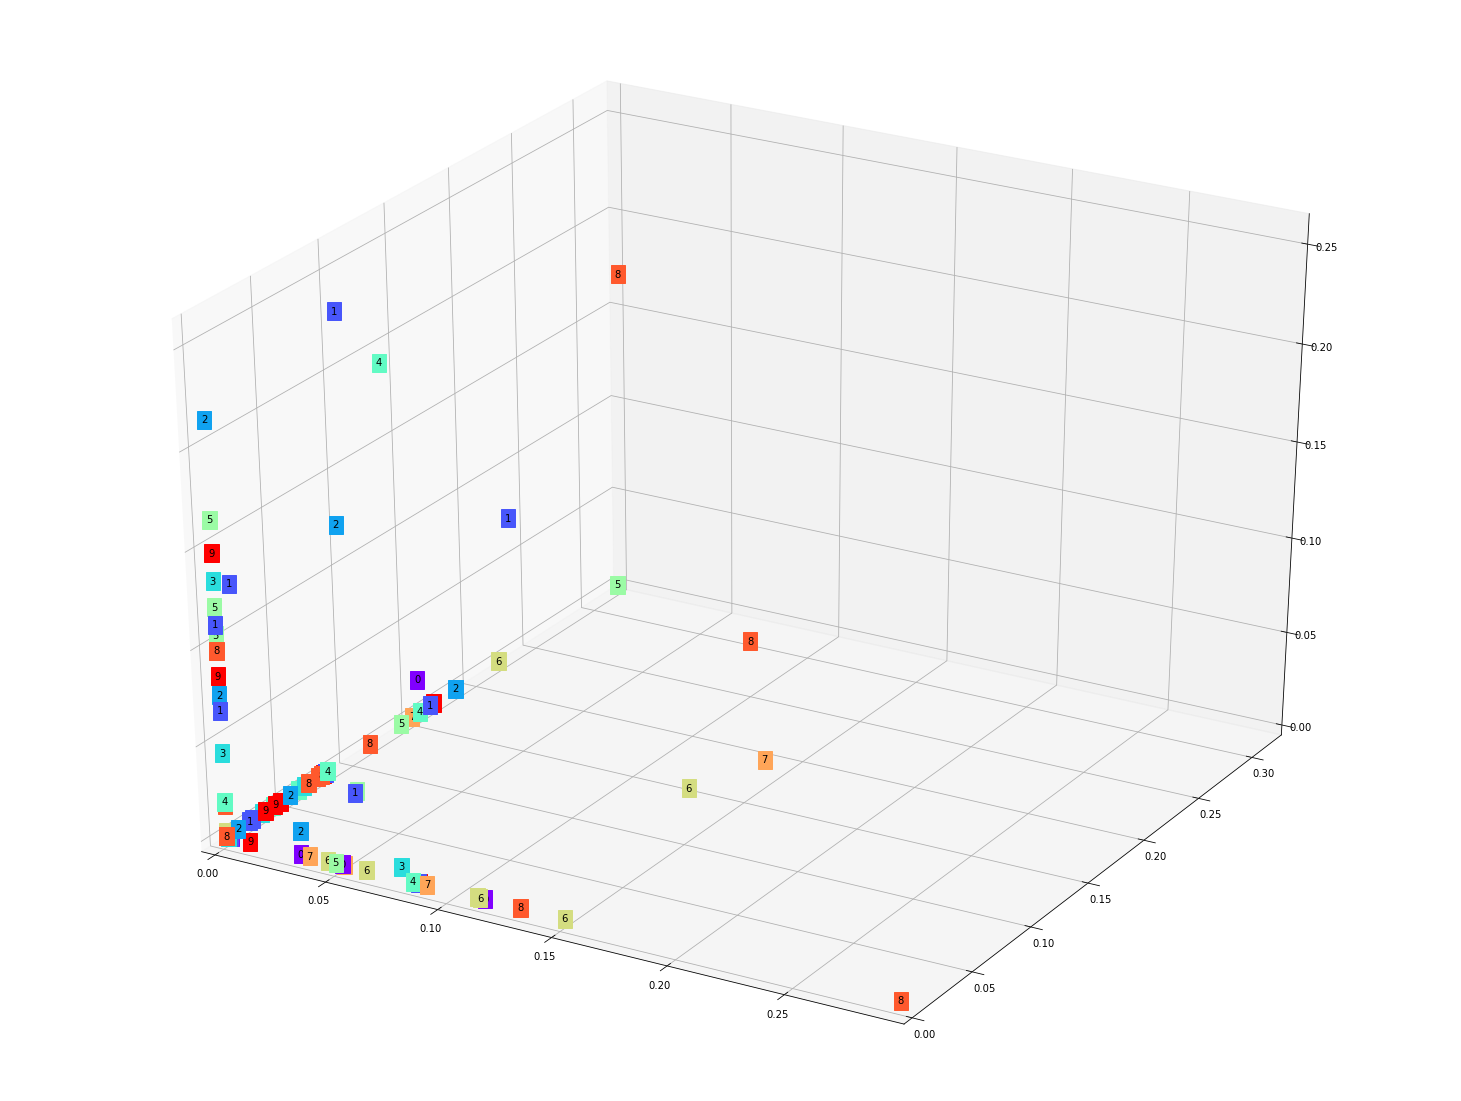

In [134]:
# visualize in 3D plot
fig = plt.figure(2, figsize=(20, 15)); ax = Axes3D(fig)
X, Y, Z = encoded_data[0,:300], encoded_data[1,:300], encoded_data[2,:300]
for x, y, z, s in zip(X, Y, Z, np.argmax(test_y, 0)):
    c = cm.rainbow(int(255*s/9)); ax.text(x, y, z, s, backgroundcolor=c)
ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
plt.show()